# Monte Carlo Methods

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

### Part 0: Environment details - BlackjackEnv

Create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:
```
    STICK = 0, HIT = 1
```

In [2]:
env = gym.make('Blackjack-v1')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Play Blackjack with a random policy (playing N times).

In [3]:
N = 3
for i_episode in range(N):
    state = env.reset()
    # Keep playing until 'done'
    while True:
        print(state)
        # Here we sample randomly from the action space.
        action = env.action_space.sample()
        print(action)
        # and then take one step with this action:
        state, reward, done, info = env.step(action)
        if done:
            print(state)
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(15, 10, False)
0
(15, 10, False)
End game! Reward:  1.0
You won :)

(14, 9, False)
0
(14, 9, False)
End game! Reward:  -1.0
You lost :(

(14, 8, False)
1
(24, 8, False)
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction

##### Sampling an episode of a probabilistic policy

Policy: player _almost always sticks_, $probs=[STICK_{prob}, HIT_{prob}]$, if the sum of cards exceeds 18. Else, selects with $1 - probs$. 

The function `generate_episode` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.
- `probs`: Probabilities for the policy. 
- `sum_thresh`: Threshold to invert `probs`.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$. 

In [4]:
def generate_episode(bj_env, probs=[0.5,0.5], sum_thresh=18):
    episode = []
    state = bj_env.reset()
    while True:
        p = probs if state[0] > sum_thresh else (np.ones_like(probs)-probs)
        # Random choice from [0,1] with probability p
        action = np.random.choice(np.arange(2), p=p)
        # Use action
        next_state, reward, done, info = bj_env.step(action)
        # Append to trajectory list
        episode.append((state, action, reward))
        # Update state
        state = next_state
        if done:
            break
    return episode

##### MC prediction for estimating the action-value function.  

Either *first-visit* or *every-visit* MC prediction: in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [5]:
def mc_prediction_q(env, num_episodes, generate_episode, probs=[0.5,0.5], sum_thresh=18, gamma=1.0):
    # Initialization
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Main loop
    for i_episode in range(1, num_episodes+1):
        # Print progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate episode
        episode = generate_episode(env, probs, sum_thresh)
        # Remember episode = [s0, a0, r1, ... ]
        # Python magic: obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # discounting factors
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Now obtain the action-value function estimate $Q$. 

Episode 500000/500000.

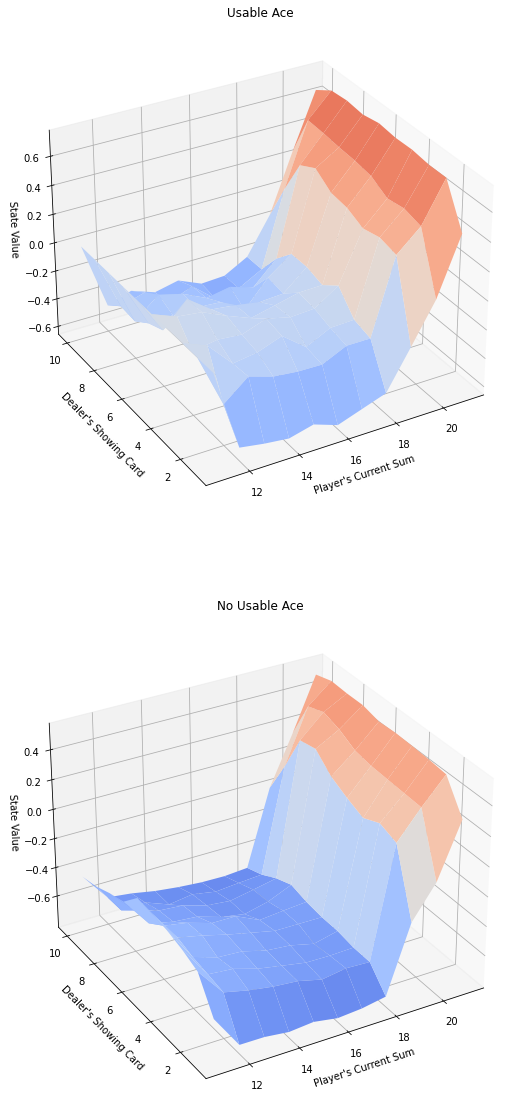

In [6]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

##### constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [18]:
def update_eps_policy(Q_s, epsilon, nA):
    # """ obtains the action probabilities corresponding to epsilon-greedy policy """
    """ Updates the π(a|s) based on Q(s,a) """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def generate_episode_from_policy(env, curr_policy):
    """ generates an episode from following the epsilon-greedy policy (curr_policy) """
    nA = env.action_space.n
    episode = []
    state = env.reset()
    while True:
        # Sample an action.
        if state in curr_policy: 
            # If we visited the state before, use curr_policy
            action = np.random.choice(np.arange(nA), p=curr_policy[state])
        else:
            # If seeing it first time, sample uniformly
            action = env.action_space.sample()
        # Apply action to curent state. 
        next_state, reward, done, info = env.step(action)
        # Append to the episode trajectory (St, At, Rt+1). 
        episode.append((state, action, reward))
        # Update state. 
        state = next_state
        if done:
            break
    return episode

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [19]:
# Updating Q is done in every-visit style
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # Initialization
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    policy = defaultdict(lambda: np.ones(nA) / nA)
    # init_policy = np.ones(nA) / nA
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # 0. Update epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # 1. Generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_policy(env, policy)
        # 2. Update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
        # 3. Update policy
        states, _, _ = zip(*episode)
        for i, state in enumerate(states):
            policy[state] = update_eps_policy(Q[state], epsilon, nA)

    # Determine the final policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function. 

In [23]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

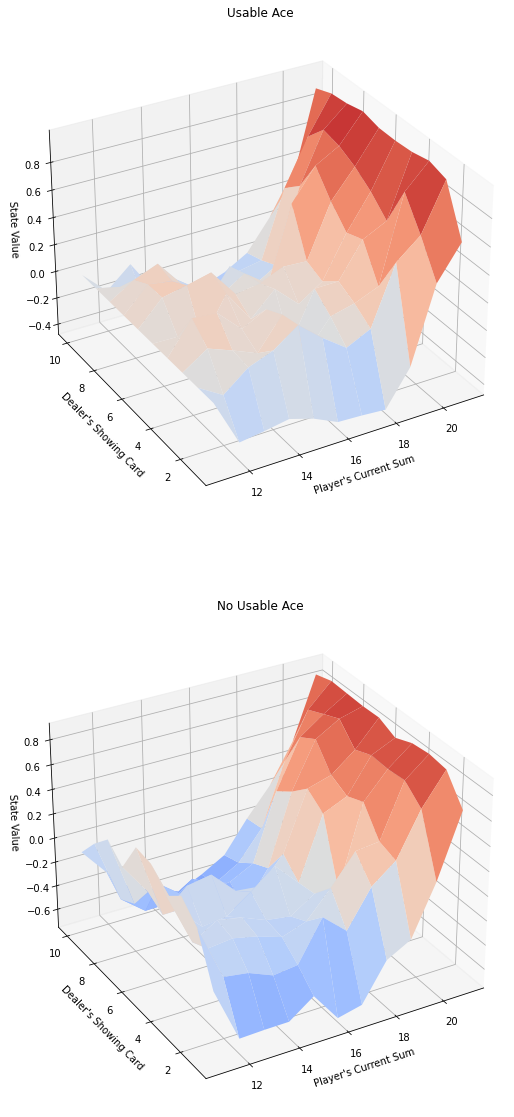

In [24]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

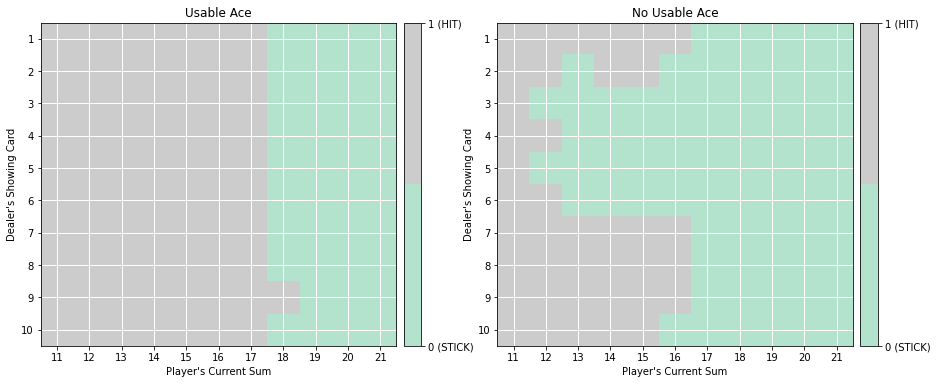

In [25]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)